In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer-image-data-set/dataset_cancer_v1/classificacao_multiclasse/200X/adenosis/SOB_B_A-14-29960CD-200-012.png
/kaggle/input/breast-cancer-image-data-set/dataset_cancer_v1/classificacao_multiclasse/200X/adenosis/SOB_B_A-14-22549AB-200-029.png
/kaggle/input/breast-cancer-image-data-set/dataset_cancer_v1/classificacao_multiclasse/200X/adenosis/SOB_B_A-14-22549AB-200-010.png
/kaggle/input/breast-cancer-image-data-set/dataset_cancer_v1/classificacao_multiclasse/200X/adenosis/SOB_B_A-14-22549CD-200-018.png
/kaggle/input/breast-cancer-image-data-set/dataset_cancer_v1/classificacao_multiclasse/200X/adenosis/SOB_B_A-14-22549CD-200-011.png
/kaggle/input/breast-cancer-image-data-set/dataset_cancer_v1/classificacao_multiclasse/200X/adenosis/SOB_B_A-14-22549AB-200-003.png
/kaggle/input/breast-cancer-image-data-set/dataset_cancer_v1/classificacao_multiclasse/200X/adenosis/SOB_B_A-14-22549AB-200-021.png
/kaggle/input/breast-cancer-image-data-set/dataset_cancer_v1/classificacao_m

In [2]:
root = "/kaggle/input/breast-cancer-image-data-set/dataset_cancer_v1"

In [3]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
import tensorflow
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications import DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools

image resize and dataset load

In [4]:


from tqdm import tqdm
import os
import cv2
import numpy as np
from PIL import Image

def denoise_image(img, h=10, hForColor=10, templateWindowSize=7, searchWindowSize=21):
    return cv2.fastNlMeansDenoisingColored(
        img, None, h, hForColor, templateWindowSize, searchWindowSize
    )

def Dataset_loader(DIR, RESIZE, h=10, hForColor=10, templateWindowSize=7, searchWindowSize=21):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR, IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE, RESIZE))
            img = denoise_image(
                img,
                h=h,
                hForColor=hForColor,
                templateWindowSize=templateWindowSize,
                searchWindowSize=searchWindowSize,
            )
            IMG.append(np.array(img))
    return IMG


In [5]:
"""
from tqdm import tqdm
import os
import cv2
import numpy as np
from PIL import Image

def denoise_image(img, h=10, templateWindowSize=7, searchWindowSize=21):
    return cv2.fastNlMeansDenoising(
        img, None, h, templateWindowSize, searchWindowSize
    )

def Dataset_loader(DIR, RESIZE, h=10, templateWindowSize=7, searchWindowSize=21):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("L"))  # Convert to grayscale
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR, IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE, RESIZE))
            img = denoise_image(
                img,
                h=h,
                templateWindowSize=templateWindowSize,
                searchWindowSize=searchWindowSize,
            )
            IMG.append(np.array(img))
    return IMG

"""

'\nfrom tqdm import tqdm\nimport os\nimport cv2\nimport numpy as np\nfrom PIL import Image\n\ndef denoise_image(img, h=10, templateWindowSize=7, searchWindowSize=21):\n    return cv2.fastNlMeansDenoising(\n        img, None, h, templateWindowSize, searchWindowSize\n    )\n\ndef Dataset_loader(DIR, RESIZE, h=10, templateWindowSize=7, searchWindowSize=21):\n    IMG = []\n    read = lambda imname: np.asarray(Image.open(imname).convert("L"))  # Convert to grayscale\n    for IMAGE_NAME in tqdm(os.listdir(DIR)):\n        PATH = os.path.join(DIR, IMAGE_NAME)\n        _, ftype = os.path.splitext(PATH)\n        if ftype == ".png":\n            img = read(PATH)\n            img = cv2.resize(img, (RESIZE, RESIZE))\n            img = denoise_image(\n                img,\n                h=h,\n                templateWindowSize=templateWindowSize,\n                searchWindowSize=searchWindowSize,\n            )\n            IMG.append(np.array(img))\n    return IMG\n\n'

In [6]:
print("100x")
benign100x = np.array(Dataset_loader('/kaggle/input/breast-cancer-image-data-set/dataset_cancer_v1/classificacao_binaria/100X/benign',64))
malignant100x = np.array(Dataset_loader('/kaggle/input/breast-cancer-image-data-set/dataset_cancer_v1/classificacao_binaria/100X/malignant',64))
print("200x")
benign200x = np.array(Dataset_loader('/kaggle/input/breast-cancer-image-data-set/dataset_cancer_v1/classificacao_binaria/200X/benign',64))
malignant200x = np.array(Dataset_loader('/kaggle/input/breast-cancer-image-data-set/dataset_cancer_v1/classificacao_binaria/200X/malignant',64))
print("400x")
benign400x = np.array(Dataset_loader('/kaggle/input/breast-cancer-image-data-set/dataset_cancer_v1/classificacao_binaria/400X/benign',64))
malignant400x = np.array(Dataset_loader('/kaggle/input/breast-cancer-image-data-set/dataset_cancer_v1/classificacao_binaria/400X/malignant',64))
print("40x")
benign40x = np.array(Dataset_loader('/kaggle/input/breast-cancer-image-data-set/dataset_cancer_v1/classificacao_binaria/40X/benign',64))
malignant40x = np.array(Dataset_loader('/kaggle/input/breast-cancer-image-data-set/dataset_cancer_v1/classificacao_binaria/40X/malignant',64))

100x


100%|██████████| 1437/1437 [01:06<00:00, 21.67it/s]


200x


100%|██████████| 1390/1390 [01:04<00:00, 21.45it/s]


400x


100%|██████████| 1232/1232 [00:51<00:00, 23.83it/s]


40x


100%|██████████| 1370/1370 [01:04<00:00, 21.21it/s]


In [7]:
t_s = 0.2

In [8]:
print("100x")

print(len(benign100x))

import sklearn.model_selection
image_dataset = benign100x
# Split the dataset into train and test sets
benign100x_train_set, benign100x_test_set = sklearn.model_selection.train_test_split(
    image_dataset, test_size=t_s
)
print(len(benign100x_train_set))
print(len(benign100x_test_set))

print("____________________________________________________________-")
print(len(malignant100x))

import sklearn.model_selection
image_dataset = malignant100x
# Split the dataset into train and test sets
malignant100x_train_set, malignant100x_test_set = sklearn.model_selection.train_test_split(
    image_dataset, test_size=t_s
)
print(len(malignant100x_train_set))
print(len(malignant100x_test_set))


100x
644
515
129
____________________________________________________________-
1437
1149
288


In [9]:
print("200x")

print(len(benign200x))

import sklearn.model_selection
image_dataset = benign200x
# Split the dataset into train and test sets
benign200x_train_set, benign200x_test_set = sklearn.model_selection.train_test_split(
    image_dataset, test_size=t_s
)
print(len(benign200x_train_set))
print(len(benign200x_test_set))

print("____________________________________________________________-")
print(len(malignant200x))

import sklearn.model_selection
image_dataset = malignant200x
# Split the dataset into train and test sets
malignant200x_train_set, malignant200x_test_set = sklearn.model_selection.train_test_split(
    image_dataset, test_size=t_s
)
print(len(malignant200x_train_set))
print(len(malignant200x_test_set))


200x
623
498
125
____________________________________________________________-
1390
1112
278


In [10]:
print("400x")

print(len(benign400x))

import sklearn.model_selection
image_dataset = benign400x
# Split the dataset into train and test sets
benign400x_train_set, benign400x_test_set = sklearn.model_selection.train_test_split(
    image_dataset, test_size=t_s
)
print(len(benign400x_train_set))
print(len(benign400x_test_set))

print("____________________________________________________________-")
print(len(malignant400x))

import sklearn.model_selection
image_dataset = malignant400x
# Split the dataset into train and test sets
malignant400x_train_set, malignant400x_test_set = sklearn.model_selection.train_test_split(
    image_dataset, test_size=t_s
)
print(len(malignant400x_train_set))
print(len(malignant400x_test_set))


400x
588
470
118
____________________________________________________________-
1232
985
247


In [11]:
print("40x")

print(len(benign40x))

import sklearn.model_selection
image_dataset = benign40x
# Split the dataset into train and test sets
benign40x_train_set, benign40x_test_set = sklearn.model_selection.train_test_split(
    image_dataset, test_size=t_s
)
print(len(benign40x_train_set))
print(len(benign40x_test_set))

print("____________________________________________________________-")
print(len(malignant40x))

import sklearn.model_selection
image_dataset = malignant40x
# Split the dataset into train and test sets
malignant40x_train_set, malignant40x_test_set = sklearn.model_selection.train_test_split(
    image_dataset, test_size=t_s
)
print(len(malignant40x_train_set))
print(len(malignant40x_test_set))


40x
625
500
125
____________________________________________________________-
1370
1096
274


In [12]:
print("total image::::::")

print(len(benign100x)+len(malignant100x)+len(benign200x)+len(malignant200x)+len(benign400x)+len(malignant400x)+len(benign40x)+len(malignant40x))

total image::::::
7909


In [13]:
print("100x")
benign100x_train_label = np.zeros(len(benign100x_train_set))
malign100x_train_label = np.ones(len(malignant100x_train_set))
benign100x_test_label = np.zeros(len(benign100x_test_set))
malign100x_test_label = np.ones(len(malignant100x_test_set))

print("200x")
benign200x_train_label = np.zeros(len(benign200x_train_set))
malign200x_train_label = np.ones(len(malignant200x_train_set))
benign200x_test_label = np.zeros(len(benign200x_test_set))
malign200x_test_label = np.ones(len(malignant200x_test_set))

print("400x")
benign400x_train_label = np.zeros(len(benign400x_train_set))
malign400x_train_label = np.ones(len(malignant400x_train_set))
benign400x_test_label = np.zeros(len(benign400x_test_set))
malign400x_test_label = np.ones(len(malignant400x_test_set))

print("40x")
benign40x_train_label = np.zeros(len(benign40x_train_set))
malign40x_train_label = np.ones(len(malignant40x_train_set))
benign40x_test_label = np.zeros(len(benign40x_test_set))
malign40x_test_label = np.ones(len(malignant40x_test_set))


100x
200x
400x
40x


In [14]:
#final
X_train = np.concatenate((benign100x_train_set, malignant100x_train_set,
                          benign200x_train_set, malignant200x_train_set,
                          benign400x_train_set, malignant400x_train_set,
                          benign40x_train_set, malignant40x_train_set), axis = 0)

Y_train = np.concatenate((benign100x_train_label, malign100x_train_label,
                         benign200x_train_label, malign200x_train_label,
                         benign400x_train_label, malign400x_train_label,
                         benign40x_train_label, malign40x_train_label), axis = 0)

X_test = np.concatenate((benign100x_test_set, malignant100x_test_set,
                        benign200x_test_set, malignant200x_test_set,
                        benign400x_test_set, malignant400x_test_set,
                        benign40x_test_set, malignant40x_test_set), axis = 0)

Y_test = np.concatenate((benign100x_test_label, malign100x_test_label,
                        benign200x_test_label, malign200x_test_label,
                        benign400x_test_label, malign400x_test_label,
                        benign40x_test_label, malign40x_test_label), axis = 0)

In [15]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(6325, 64, 64, 3)
(6325,)
(1584, 64, 64, 3)
(1584,)


In [16]:
X_train = X_train/255
X_test = X_test/255

In [17]:
X_train_flatten = X_train.reshape(len(X_train), 64*64*3)
X_test_flatten = X_test.reshape(len(X_test), 64*64*3)

In [18]:
print(X_train_flatten.shape)
print(X_test_flatten.shape)

(6325, 12288)
(1584, 12288)


In [19]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(6325, 64, 64, 3)
(6325,)
(1584, 64, 64, 3)
(1584,)


# cnn

In [20]:
from tensorflow.keras import models, layers

cnn = models.Sequential([
    
    # cnn
    layers.Conv2D(filters=256, kernel_size=(2, 2), activation='relu', padding='same', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2), strides=2),
    
    layers.Conv2D(filters=128,kernel_size=(2, 2), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), strides=2),
    
    layers.Conv2D(filters=64, kernel_size=(2, 2), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), strides=2),
    
    layers.Conv2D(filters=32, kernel_size=(2, 2), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), strides=2),
    
    layers.Conv2D(filters=16, kernel_size=(2, 2), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), strides=2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')    
])


In [21]:
cnn.compile(optimizer='RMSProp',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
r = cnn.fit(X_train, Y_train, epochs=50, batch_size=75, validation_data=(X_test, Y_test))

Epoch 1/50
85/85 [==============================] - 152s 2s/step - loss: 0.5812 - accuracy: 0.6969 - val_loss: 0.5791 - val_accuracy: 0.7165
Epoch 2/50
85/85 [==============================] - 150s 2s/step - loss: 0.5135 - accuracy: 0.7673 - val_loss: 0.5012 - val_accuracy: 0.7626
Epoch 3/50
85/85 [==============================] - 148s 2s/step - loss: 0.4936 - accuracy: 0.7855 - val_loss: 0.8000 - val_accuracy: 0.6143
Epoch 4/50
85/85 [==============================] - 148s 2s/step - loss: 0.4799 - accuracy: 0.7981 - val_loss: 0.5567 - val_accuracy: 0.7235
Epoch 5/50
85/85 [==============================] - 148s 2s/step - loss: 0.4711 - accuracy: 0.8021 - val_loss: 0.4305 - val_accuracy: 0.8403
Epoch 6/50
85/85 [==============================] - 147s 2s/step - loss: 0.4621 - accuracy: 0.8123 - val_loss: 0.4127 - val_accuracy: 0.8390
Epoch 7/50
85/85 [==============================] - 148s 2s/step - loss: 0.4618 - accuracy: 0.8114 - val_loss: 0.6580 - val_accuracy: 0.6944
Epoch 8/50
85

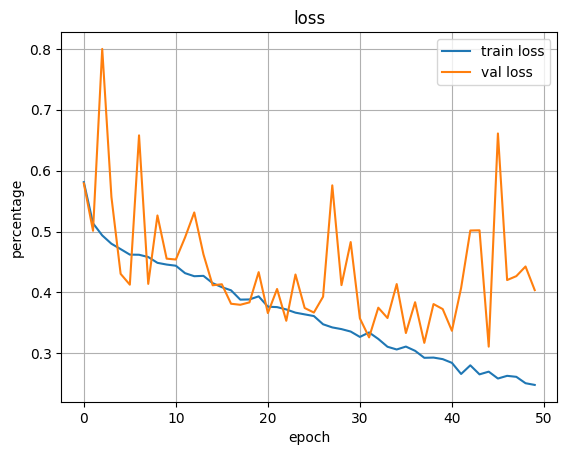

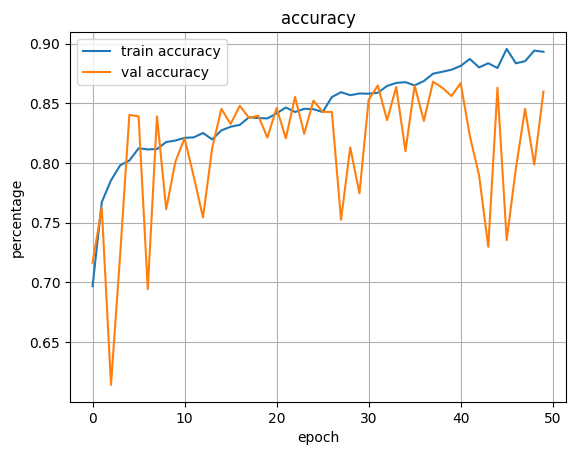

In [23]:
plt.grid()
plt.xlabel("epoch")
plt.ylabel('percentage')
plt.title('loss')
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()


plt.grid()
plt.xlabel("epoch")
plt.ylabel('percentage')
plt.title('accuracy')
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()


